# 1. Fitting the parity function

Here by use of quantum varaiational classifier and Pennylane platform, a parit function is emulated.
$\newline$
Parity function is $f: x\in\{0,1\}^{\otimes n}\rightarrow y=\begin{cases} 1 & \text{if uneven number of 1's in x} \\0 &  \text{else.}\end{cases}$
$\newline$
To do so we follow steps:
$\newline$
1-provide the state prepartion circuit **(comparing basisencoding and IQPEmbedding)**
$\newline$
2-intoduce quanutm circuit with learnable parameters in different layers
$\newline$
3-introduce a cost function
$\newline$
4-using optimization to optimized learning parameter via minimizing the cost function

In [1]:
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import NesterovMomentumOptimizer

In [2]:
qml.version()#check what version of pennylane using

'0.37.0'

In [3]:
dev = qml.device("default.qubit",wires=4) #determine the device which simulates the quantum circuite

**Function layer involves #wires (=4) rotation gates indicated by Rot which needs three parameters to be defined in the first layer. After these single qubit gates, a cyclic set of CNOT gates (two-qubit gate) is applied. A quanutm circuit may have several of this layer**

In [4]:
def layer(layer_weights):
    for wire in range(4):
        qml.Rot(*layer_weights[wire], wires=wire)

    for wires in ([0, 1], [1, 2], [2, 3], [3, 0]):
        qml.CNOT(wires)

In the following you find out what is the role of * before argument layer_weights[wire] of qml.Rot in above function.

In [5]:
def ex_layer_weights(w):
    return w[0], w[1]


def Rot(phi, teta):
    print(phi, teta)


w = [1, 2]
print(ex_layer_weights(w))
Rot(*ex_layer_weights(w))

(1, 2)
1 2


## 1-State preparation

**It is used basis encoding which encode bitstring 01001 in $|01001\rangle$ by applying not gate (pauli X) on second and fifth qubits. It is clear that the number of bits in a string indicates the number of reqired qubits.**

In [6]:
def state_preparation(x):
    qml.BasisState(x, wires=[0, 1, 2, 3])
    
#Encodes n features into n qubits using diagonal gates of an IQP circuit.    
def state_preparation_n(x):
    qml.IQPEmbedding(x, wires=[0, 1, 2, 3], n_repeats=1)

## 2-Quantum circuit 

**It consists of state preparation and parametrized quantum circuit. In the measurment part only the expectation value of pauli $Z$ of qubit 0 is evaluated.**

In [7]:
@qml.qnode(dev)
def circuit(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))
@qml.qnode(dev)
def circuit_n(weights, x):
    state_preparation(x)

    for layer_weights in weights:
        layer(layer_weights)

    return qml.expval(qml.PauliZ(0))

Function entitled variational_classifier introduce learnable parameters, i.e., a bias to the output of the circuit.

In [8]:
def variational_classifier(weights, bias, x):
    return circuit(weights, x) + bias

def variational_classifier_n(weights, bias, x):
    return circuit_n(weights, x) + bias

Function entitled square_loss calculates L2 norm between the real lables and predicted labels. 

In [9]:
def square_loss(labels, predictions):
    # We use a call to qml.math.stack to allow subtracting the arrays directly
    return np.mean((labels - qml.math.stack(predictions)) ** 2)

Function accuracy numerates the number of predicted lables which are as close as the real lables with the precision of 1e-5.

In [10]:
def accuracy(labels, predictions):
    acc = sum(abs(l - p) < 1e-5 for l, p in zip(labels, predictions))
    acc = acc / len(labels)
    return acc

## 3-cost function

Function cost introduces a loss function for training the parameters (weights and bias).

In [11]:
def cost(weights, bias, X, Y):
    predictions = [variational_classifier(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

def cost_n(weights, bias, X, Y):
    predictions = [variational_classifier_n(weights, bias, x) for x in X]
    return square_loss(Y, predictions)

The training and test date are provided (visit:https://pennylane.ai/qml/demos/tutorial_variational_classifier/)

In [12]:
data = np.loadtxt("variational_classifier/data/parity_train.txt", dtype=int)
X = np.array(data[:, :-1])
Y = np.array(data[:, -1])
Y = Y * 2 - 1  # shift label from {0, 1} to {-1, 1}

for x,y in zip(X, Y):
    print(f"x = {x}, y = {y}")

x = [0 0 0 1], y = 1
x = [0 0 1 0], y = 1
x = [0 1 0 0], y = 1
x = [0 1 0 1], y = -1
x = [0 1 1 0], y = -1
x = [0 1 1 1], y = 1
x = [1 0 0 0], y = 1
x = [1 0 0 1], y = -1
x = [1 0 1 1], y = 1
x = [1 1 1 1], y = -1


Number of qubits and number of layers and intialization of weights and bias are determined. 

In [13]:
np.random.seed(0)
num_qubits = 4
num_layers = 2
weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

print("Weights:", weights_init)
print("Bias: ", bias_init)

Weights: [[[ 0.01764052  0.00400157  0.00978738]
  [ 0.02240893  0.01867558 -0.00977278]
  [ 0.00950088 -0.00151357 -0.00103219]
  [ 0.00410599  0.00144044  0.01454274]]

 [[ 0.00761038  0.00121675  0.00443863]
  [ 0.00333674  0.01494079 -0.00205158]
  [ 0.00313068 -0.00854096 -0.0255299 ]
  [ 0.00653619  0.00864436 -0.00742165]]]
Bias:  0.0


For beginner of python in following one finds what qml.math.stack does to the data. 

In [14]:
a = variational_classifier(weights_init, bias_init, X[0])
b = [variational_classifier(weights_init, bias_init, x) for x in X]
c = qml.math.stack(b)
print(a)
print()
print(b)
print()
print(c)

-0.9996315872705979

[tensor(-0.99963159, requires_grad=True), tensor(0.99963075, requires_grad=True), tensor(-0.99963159, requires_grad=True), tensor(0.9996316, requires_grad=True), tensor(-0.99963074, requires_grad=True), tensor(0.99963075, requires_grad=True), tensor(-0.99963075, requires_grad=True), tensor(0.99963074, requires_grad=True), tensor(0.99963159, requires_grad=True), tensor(-0.9996316, requires_grad=True)]

[-0.99963159  0.99963075 -0.99963159  0.9996316  -0.99963074  0.99963075
 -0.99963075  0.99963074  0.99963159 -0.9996316 ]


**Demonstration of the quantum circuit.**

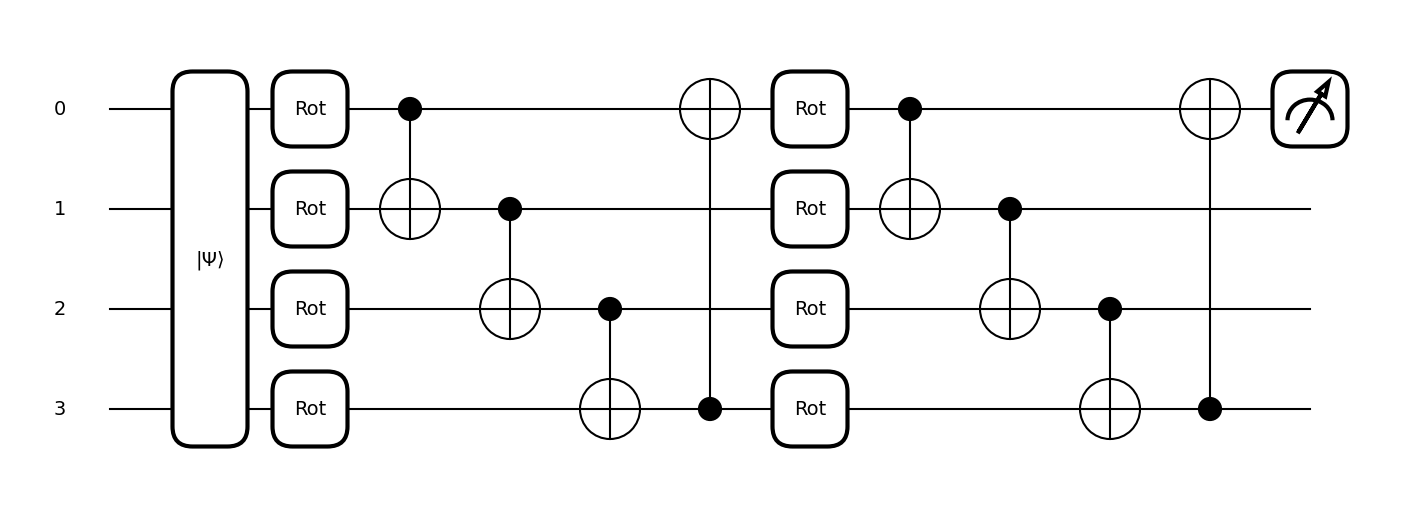

In [15]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
fig, ax = qml.draw_mpl(circuit)(weights_init, X)
plt.show()

## 4-Optimization and training

In [16]:
opt = NesterovMomentumOptimizer(0.5)
batch_size = 5

**For beginner to python**

In [17]:
batch_index = np.random.randint(0, len(X), (batch_size,))
print(batch_index,',','|X|=',len(X),',','batch_size=',(batch_size,))

[7 2 0 0 4] , |X|= 10 , batch_size= (5,)


In [18]:
batch_index

tensor([7, 2, 0, 0, 4], requires_grad=True)

In [19]:
X_batch = X[batch_index]
X_batch

tensor([[1, 0, 0, 1],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 0, 1],
        [0, 1, 1, 0]], requires_grad=True)

Weights and bias iteratively are updated by NesterovMomentumOptimizer(0.5)

In [20]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions = [np.sign(variational_classifier(weights, bias, x)) for x in X]

    current_cost = cost(weights, bias, X, Y)
    acc = accuracy(Y, predictions)

    print(f"Iter: {it+1:4d} | Cost: {current_cost:0.7f} | Accuracy: {acc:0.7f}")

Iter:    1 | Cost: 1.9985847 | Accuracy: 0.5000000
Iter:    2 | Cost: 1.9968864 | Accuracy: 0.5000000
Iter:    3 | Cost: 2.9444160 | Accuracy: 0.5000000
Iter:    4 | Cost: 1.6996819 | Accuracy: 0.5000000
Iter:    5 | Cost: 1.8127072 | Accuracy: 0.5000000
Iter:    6 | Cost: 2.2275757 | Accuracy: 0.5000000
Iter:    7 | Cost: 2.7902642 | Accuracy: 0.5000000
Iter:    8 | Cost: 1.8201117 | Accuracy: 0.5000000
Iter:    9 | Cost: 1.2341103 | Accuracy: 0.4000000
Iter:   10 | Cost: 0.9850669 | Accuracy: 0.6000000
Iter:   11 | Cost: 0.9696628 | Accuracy: 0.4000000
Iter:   12 | Cost: 1.1294192 | Accuracy: 0.6000000
Iter:   13 | Cost: 2.1292253 | Accuracy: 0.4000000
Iter:   14 | Cost: 0.9336925 | Accuracy: 0.5000000
Iter:   15 | Cost: 1.1321898 | Accuracy: 0.6000000
Iter:   16 | Cost: 1.3851188 | Accuracy: 0.6000000
Iter:   17 | Cost: 1.1801214 | Accuracy: 0.5000000
Iter:   18 | Cost: 1.5021596 | Accuracy: 0.5000000
Iter:   19 | Cost: 1.5894239 | Accuracy: 0.6000000
Iter:   20 | Cost: 1.4247532 | 

# Now we use IQPEmbedding (note that after 22 iretation accuracy convergaes to 1. However, basisencoding requires 41.)

In [21]:
weights = weights_init
bias = bias_init
for it in range(100):

    # Update the weights by one optimizer step, using only a limited batch of data
    batch_index = np.random.randint(0, len(X), (batch_size,))
    X_batch = X[batch_index]
    Y_batch = Y[batch_index]
    weights, bias = opt.step(cost_n, weights, bias, X=X_batch, Y=Y_batch)

    # Compute accuracy
    predictions_n = [np.sign(variational_classifier_n(weights, bias, x)) for x in X]

    current_cost_n = cost_n(weights, bias, X, Y)
    acc_n = accuracy(Y, predictions_n)

    print(f"Iter: {it+1:4d} | Cost: {current_cost_n:0.7f} | Accuracy: {acc_n:0.7f}")

Iter:    1 | Cost: 1.9962340 | Accuracy: 0.5000000
Iter:    2 | Cost: 2.2895355 | Accuracy: 0.5000000
Iter:    3 | Cost: 1.8089367 | Accuracy: 0.5000000
Iter:    4 | Cost: 1.0294440 | Accuracy: 0.7000000
Iter:    5 | Cost: 1.0636633 | Accuracy: 0.6000000
Iter:    6 | Cost: 0.9531088 | Accuracy: 0.6000000
Iter:    7 | Cost: 1.5555067 | Accuracy: 0.6000000
Iter:    8 | Cost: 0.9691189 | Accuracy: 0.5000000
Iter:    9 | Cost: 1.7955508 | Accuracy: 0.6000000
Iter:   10 | Cost: 1.6932347 | Accuracy: 0.4000000
Iter:   11 | Cost: 1.3492208 | Accuracy: 0.4000000
Iter:   12 | Cost: 1.3475815 | Accuracy: 0.4000000
Iter:   13 | Cost: 0.9844874 | Accuracy: 0.6000000
Iter:   14 | Cost: 1.0972268 | Accuracy: 0.4000000
Iter:   15 | Cost: 1.0557568 | Accuracy: 0.4000000
Iter:   16 | Cost: 0.8614362 | Accuracy: 0.6000000
Iter:   17 | Cost: 1.2200153 | Accuracy: 0.8000000
Iter:   18 | Cost: 1.0417840 | Accuracy: 0.7000000
Iter:   19 | Cost: 0.9509019 | Accuracy: 0.4000000
Iter:   20 | Cost: 0.8133375 | 

In [22]:
data = np.loadtxt("variational_classifier/data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


In [23]:
data = np.loadtxt("variational_classifier/data/parity_test.txt", dtype=int)
X_test = np.array(data[:, :-1])
X_test = np.array(data[:, :-1])
Y_test = np.array(data[:, -1])
Y_test = Y_test * 2 - 1  # shift label from {0, 1} to {-1, 1}

predictions_test = [np.sign(variational_classifier_n(weights, bias, x)) for x in X_test]

for x,y,p in zip(X_test, Y_test, predictions_test):
    print(f"x = {x}, y = {y}, pred={p}")

acc_test = accuracy(Y_test, predictions_test)
print("Accuracy on unseen data:", acc_test)

x = [0 0 0 0], y = -1, pred=-1.0
x = [0 0 1 1], y = -1, pred=-1.0
x = [1 0 1 0], y = -1, pred=-1.0
x = [1 1 1 0], y = 1, pred=1.0
x = [1 1 0 0], y = -1, pred=-1.0
x = [1 1 0 1], y = 1, pred=1.0
Accuracy on unseen data: 1.0


# 2. Iris classification

 Iris dataset is two dimentional real-valued vectors. This data set is accompanied by the latent dimensions. Therefore, instead of using basis encoding, rotation encoding is utilized on two qubits. Every input is translated as angles that information of that data encoded in via rotation gates. 

The dataset has 4 components. The following function (get_angles) encodes the information of X in to five angles. https://pennylane.ai/qml/demos/tutorial_variational_classifier/

## 1-state preparation

The rutine for encoding input to quantum state is implemented using the two following function: (see reference https://arxiv.org/pdf/quant-ph/0407010)

In [24]:
def get_angles(x):
    beta0 = 2 * np.arcsin(np.sqrt(x[1] ** 2) / np.sqrt(x[0] ** 2 + x[1] ** 2 + 1e-12))
    beta1 = 2 * np.arcsin(np.sqrt(x[3] ** 2) / np.sqrt(x[2] ** 2 + x[3] ** 2 + 1e-12))
    beta2 = 2 * np.arcsin(np.linalg.norm(x[2:]) / np.linalg.norm(x))

    return np.array([beta2, -beta1 / 2, beta1 / 2, -beta0 / 2, beta0 / 2])


def state_preparation(a):
    qml.RY(a[0], wires=0)

    qml.CNOT(wires=[0, 1])
    qml.RY(a[1], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[2], wires=1)

    qml.PauliX(wires=0)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[3], wires=1)
    qml.CNOT(wires=[0, 1])
    qml.RY(a[4], wires=1)
    qml.PauliX(wires=0)

**The quantum circuit for encoding data**

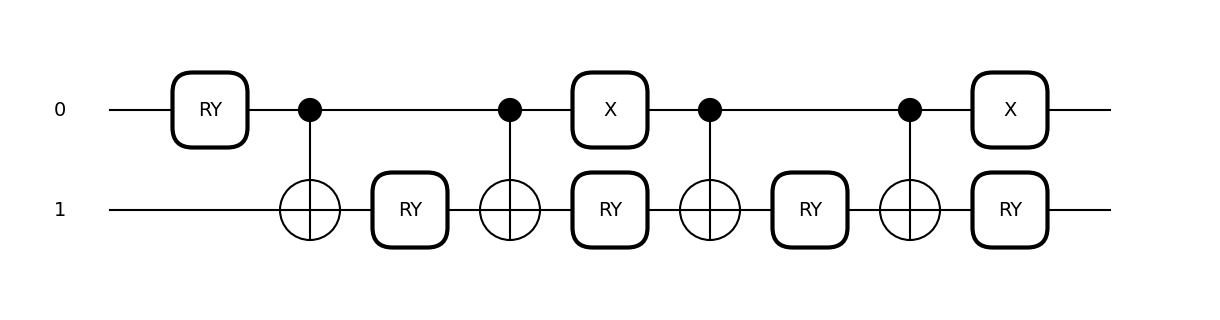

In [25]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
params = np.array([0]*5)
fig, ax = qml.draw_mpl(state_preparation)(params)
plt.show()

**Testing if the output of the quantum encoding circuit leads to the real data**

In [26]:
x = np.array([0.53896774, 0.79503606, 0.27826503, 0.0], requires_grad=False)
ang = get_angles(x)


@qml.qnode(dev)
def test(angles):
    state_preparation(angles)

    return qml.state()


state = test(ang)

print("x               : ", np.round(x, 6))
print("angles          : ", np.round(ang, 6))
print("amplitude vector: ", np.round(np.real(state), 6))

x               :  [0.538968 0.795036 0.278265 0.      ]
angles          :  [ 0.563975 -0.        0.       -0.975046  0.975046]
amplitude vector:  [ 0.538968  0.        0.        0.        0.795036  0.        0.
  0.        0.278265  0.        0.        0.       -0.        0.
  0.        0.      ]


**Since data set is encoded on two qubit, training layer function must be modified**

In [27]:
def layer(layer_weights):
    for wire in range(2):
        qml.Rot(*layer_weights[wire], wires=wire)
    qml.CNOT(wires=[0, 1])

**Demonstration of the layer**

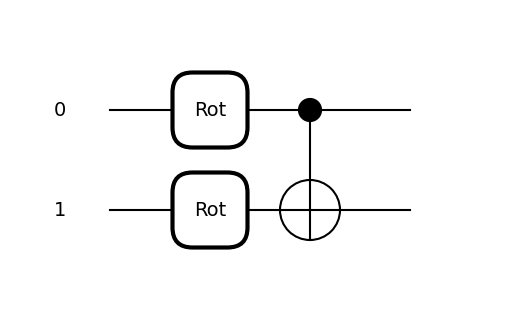

In [28]:
import matplotlib.pyplot as plt
qml.drawer.use_style("black_white")
par = [[0,0,0],[0,0,0]]
fig, ax = qml.draw_mpl(layer)(par)
plt.show()

**Cost function based on square_loss function L2 norm of the difference between prdicted value by QC and the real data label**

In [29]:
def cost(weights, bias, X, Y):
    # Transpose the batch of input data in order to make the indexing
    # in state_preparation work
    predictions = variational_classifier(weights, bias, X.T)
    return square_loss(Y, predictions)

Loading data- Padding data - Normalizing data

In [30]:
data = np.loadtxt("variational_classifier/data/Iris.txt")
X = data[:, 0:2]
print(f"First X sample (original)  : {X[0]}")

# pad the vectors to size 2^2=4 with constant values
padding = np.ones((len(X), 2)) * 0.1
X_pad = np.c_[X, padding]
print(f"First X sample (padded)    : {X_pad[0]}")

# normalize each input
normalization = np.sqrt(np.sum(X_pad**2, -1))
X_norm = (X_pad.T / normalization).T
print(f"First X sample (normalized): {X_norm[0]}")

# the angles for state preparation are the features
features = np.array([get_angles(x) for x in X_norm], requires_grad=False)
print(f"First features sample      : {features[0]}")

Y = data[:, -1]

First X sample (original)  : [0.4  0.75]
First X sample (padded)    : [0.4  0.75 0.1  0.1 ]
First X sample (normalized): [0.46420708 0.87038828 0.11605177 0.11605177]
First features sample      : [ 0.32973573 -0.78539816  0.78539816 -1.080839    1.080839  ]


The following figures show how original data, padded normalized data, and feature vectores are distributed and distinguished based on their labels. 

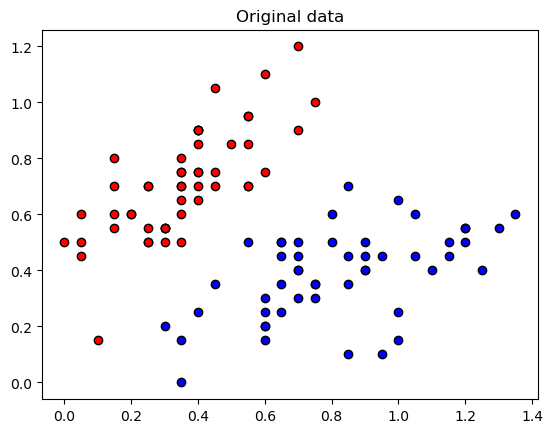

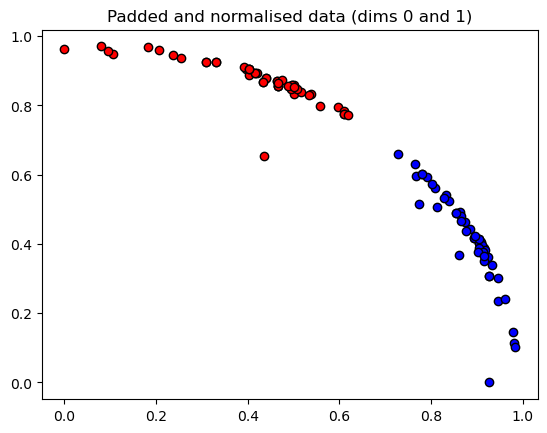

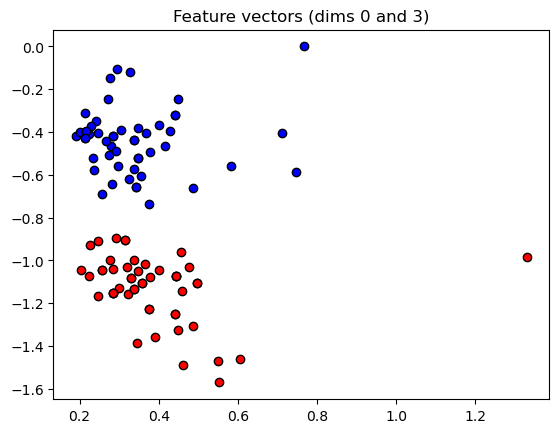

In [31]:
import matplotlib.pyplot as plt

plt.figure()
plt.scatter(X[:, 0][Y == 1], X[:, 1][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X[:, 0][Y == -1], X[:, 1][Y == -1], c="r", marker="o", ec="k")
plt.title("Original data")
plt.show()

plt.figure()
dim1 = 0
dim2 = 1
plt.scatter(X_norm[:, dim1][Y == 1], X_norm[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(X_norm[:, dim1][Y == -1], X_norm[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Padded and normalised data (dims {dim1} and {dim2})")
plt.show()

plt.figure()
dim1 = 0
dim2 = 3
plt.scatter(features[:, dim1][Y == 1], features[:, dim2][Y == 1], c="b", marker="o", ec="k")
plt.scatter(features[:, dim1][Y == -1], features[:, dim2][Y == -1], c="r", marker="o", ec="k")
plt.title(f"Feature vectors (dims {dim1} and {dim2})")
plt.show()

**Separating training data and validation data**

In [32]:
np.random.seed(0)
num_data = len(Y)
num_train = int(0.75 * num_data)
index = np.random.permutation(range(num_data))
feats_train = features[index[:num_train]]
Y_train = Y[index[:num_train]]
feats_val = features[index[num_train:]]
Y_val = Y[index[num_train:]]

# We need these later for plotting
X_train = X[index[:num_train]]
X_val = X[index[num_train:]]

**Initialize the quanutm network parameters, depth, and width**

In [33]:
num_qubits = 2
num_layers = 6

weights_init = 0.01 * np.random.randn(num_layers, num_qubits, 3, requires_grad=True)
bias_init = np.array(0.0, requires_grad=True)

# Optimization

In [34]:
opt = NesterovMomentumOptimizer(0.01)
batch_size = 5

# train the variational classifier
weights = weights_init
bias = bias_init
for it in range(60):
    # Update the weights by one optimizer step
    batch_index = np.random.randint(0, num_train, (batch_size,))
    feats_train_batch = feats_train[batch_index]
    Y_train_batch = Y_train[batch_index]
    weights, bias, _, _ = opt.step(cost, weights, bias, feats_train_batch, Y_train_batch)

    # Compute predictions on train and validation set
    predictions_train = np.sign(variational_classifier(weights, bias, feats_train.T))
    predictions_val = np.sign(variational_classifier(weights, bias, feats_val.T))

    # Compute accuracy on train and validation set
    acc_train = accuracy(Y_train, predictions_train)
    acc_val = accuracy(Y_val, predictions_val)

    if (it + 1) % 2 == 0:
        _cost = cost(weights, bias, features, Y)
        print(
            f"Iter: {it + 1:5d} | Cost: {_cost:0.7f} | "
            f"Acc train: {acc_train:0.7f} | Acc validation: {acc_val:0.7f}"
        )

Iter:     2 | Cost: 1.6589456 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:     4 | Cost: 1.2054273 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:     6 | Cost: 0.9740740 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:     8 | Cost: 0.9660872 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    10 | Cost: 0.9569019 | Acc train: 0.6000000 | Acc validation: 0.6000000
Iter:    12 | Cost: 0.9445863 | Acc train: 0.4933333 | Acc validation: 0.7200000
Iter:    14 | Cost: 1.0339978 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    16 | Cost: 1.0774217 | Acc train: 0.4933333 | Acc validation: 0.5600000
Iter:    18 | Cost: 0.9984426 | Acc train: 0.4800000 | Acc validation: 0.5600000
Iter:    20 | Cost: 0.8975279 | Acc train: 0.5600000 | Acc validation: 0.7600000
Iter:    22 | Cost: 0.8451699 | Acc train: 0.6400000 | Acc validation: 0.6400000
Iter:    24 | Cost: 0.8337489 | Acc train: 0.5600000 | Acc validation: 0.5200000
Iter:    26 | Cost: 0.783202

The following codes visualize the continuous output of the variational classifier for the first two dimensions of the Iris dataset. Line [0,0] related to z=0 indicates the boundry that classifies the data.

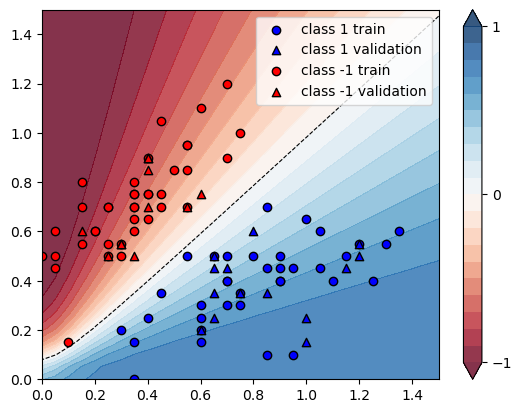

In [35]:
plt.figure()
cm = plt.cm.RdBu

# make data for decision regions
xx, yy = np.meshgrid(np.linspace(0.0, 1.5, 30), np.linspace(0.0, 1.5, 30))
X_grid = [np.array([x, y]) for x, y in zip(xx.flatten(), yy.flatten())]

# preprocess grid points like data inputs above
padding = 0.1 * np.ones((len(X_grid), 2))
X_grid = np.c_[X_grid, padding]  # pad each input
normalization = np.sqrt(np.sum(X_grid**2, -1))
X_grid = (X_grid.T / normalization).T  # normalize each input
features_grid = np.array([get_angles(x) for x in X_grid])  # angles are new features
predictions_grid = variational_classifier(weights, bias, features_grid.T)
Z = np.reshape(predictions_grid, xx.shape)

# plot decision regions
levels = np.arange(-1, 1.1, 0.1)
cnt = plt.contourf(xx, yy, Z, levels=levels, cmap=cm, alpha=0.8, extend="both")
plt.contour(xx, yy, Z, levels=[0.0], colors=("black",), linestyles=("--",), linewidths=(0.8,))
plt.colorbar(cnt, ticks=[-1, 0, 1])

# plot data
for color, label in zip(["b", "r"], [1, -1]):
    plot_x = X_train[:, 0][Y_train == label]
    plot_y = X_train[:, 1][Y_train == label]
    plt.scatter(plot_x, plot_y, c=color, marker="o", ec="k", label=f"class {label} train")
    plot_x = (X_val[:, 0][Y_val == label],)
    plot_y = (X_val[:, 1][Y_val == label],)
    plt.scatter(plot_x, plot_y, c=color, marker="^", ec="k", label=f"class {label} validation")


plt.legend()
plt.show()